# ADS Thesis Project - Boosting Model Goat

**Authors: Marion Späth (2772981)**


This notebook documents the Boosting Models for goat herders.
The datasets have been created in the R file "ML PREPARATIONS.Rmd".

In [1]:
#!pip install shap
#! pip install catboost
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import os

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor, Pool

# with pickle we can save the model, helps with long computation times
import pickle

### Import datasets

In [2]:
pd.set_option('display.max_columns', None) # show all columns in output

# set working directory
os.chdir('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/ML_training')

# load train and test data (previously created in the ElasticNet notebook)
train_goat = pd.read_csv("train_goat_df.csv")
test_goat = pd.read_csv("test_goat_df.csv")
test_goat.head(2)

,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,educ_recoded_constant_num,eng_language,expend,irrigated_land_bin,cs_cs_diff_post_goat,cs_cs_ratio_post_goat,number_minors,educ_child_recoded,educ_child_recodedNUMERIC,activity_child_recoded,household_description,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,why_not_purchase_recoded,know_vip,trust_vip,age_constant_z,number_adults_z,number_minors_z,educ_child_z,educ_adult_z,cs_diff_log,resid_mixed
0,4,4,No,35,Yes,No,Never attended,1,No,0,0,-53.165897,0.0,3,Elementary,7,Student,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,-0.488589,-0.191439,-0.140337,0.922786,-0.474056,3.992052,-0.781516
1,12,4,No,30,No,No,Never attended,1,No,0,0,-115.108932,0.0,3,Never attended school,0,Working with Livestock,Fully settled: The whole of the household (all...,3,Interpersonal Sources,Christian,0,Yes,Lack of Awareness or Understanding,No,No,-0.786820,0.582578,-0.140337,-0.899432,-0.474056,4.754529,-0.050775


In [3]:
new_df = pd.read_excel("all_y_v3.xlsx")
new_col = new_df[["id", "vip_trust_scale_r2", "vip_trust_scale_r3", "vip_trust_scale_r4"]]

# Transform dataframe form wide format into long format 
df_trust_long = pd.wide_to_long(
    new_col,
    stubnames=["vip_trust_scale"],
    i="id",
    j="wave",
    sep="_r"
).reset_index()

df_trust_long.head(2)

,id,wave,vip_trust_scale
0,1,2,1.50
1,2,2,1.75


In [4]:
train_goat = train_goat.merge(df_trust_long, on=['id', 'wave'], how='left')
test_goat = test_goat.merge(df_trust_long, on=['id', 'wave'], how='left')

train_goat['vip_trust_scale'] = (train_goat['vip_trust_scale'] - train_goat['vip_trust_scale'].mean()) / train_goat['vip_trust_scale'].std()
test_goat['vip_trust_scale'] = (test_goat['vip_trust_scale'] - test_goat['vip_trust_scale'].mean()) / test_goat['vip_trust_scale'].std()

train_goat.head(2)

,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,educ_recoded_constant_num,eng_language,expend,irrigated_land_bin,cs_cs_diff_post_goat,cs_cs_ratio_post_goat,number_minors,educ_child_recoded,educ_child_recodedNUMERIC,activity_child_recoded,household_description,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,why_not_purchase_recoded,know_vip,trust_vip,age_constant_z,number_adults_z,number_minors_z,educ_child_z,educ_adult_z,cs_diff_log,resid_mixed,vip_trust_scale
0,1,4,No,25,Yes,No,Never attended,1,No,0,1,-120.671875,0.0,2,Never attended school,0,Working with Livestock,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,Lack of Awareness or Understanding,Yes,Yes,-1.085051,-0.191439,-0.754558,-0.899432,-0.474056,4.801328,-0.026184,-0.922842
1,2,4,Yes,27,Yes,No,Adult Education,17,No,0,0,-758.621033,0.0,2,Never attended school,0,Not working,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,-0.965759,-0.191439,-0.754558,-0.899432,3.478166,6.632820,1.683224,0.653320


# Original Model with Education as a Categorical Variable

### Prepare Datasets for Models

Create dummies for categorical variables and split X and Y values for both test and train data.

In [5]:
# Prepare X and Y training sets for models
X_goat = train_goat.copy
X_goat = train_goat.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_goat", "cs_cs_ratio_post_goat", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults", 
                              "number_minors", "age_constant", "educ_child_z", "educ_adult_z", "cs_diff_log"], axis=1)

Y_goat = train_goat["resid_mixed"]

X_goat_TEST = test_goat.copy
X_goat_TEST = test_goat.drop(["resid_mixed", "id", "wave", "cs_cs_diff_post_goat", "cs_cs_ratio_post_goat", "educ_recoded_constant_num", "educ_child_recodedNUMERIC", "number_adults",
                                   "number_minors", "age_constant", "educ_child_z", "educ_adult_z", "cs_diff_log"], axis=1)

Y_goat_TEST = test_goat["resid_mixed"]

#### Specify Categorical Features, Set Up Hyperparameters and Performance Indicators

Prepare cross-validation using grid search including all available hyperparameters and specifying performance metrics to incluede the (negative) mean squared error, (negative) mean absolute error, and R Squared. Sklearn calculate the negative values so that the interpretation of "the higher the better" is valid across all performance metrics.

In [7]:
# Specify categorical variables 
cat_features = ['afm_language', 'agric_land', 'amh_language', 'eng_language', 'expend', 'irrigated_land_bin', 'educ_child_recoded', 'educ_recoded_constant',
                'activity_child_recoded', 'household_description', 'main_info_source_recoded', 'religion_recoded', 'owns_phone', 'household_moved',
                'why_not_purchase_recoded', 'know_vip', 'trust_vip'] 


# Ensure categorical columns are string/categorical for compatibility
for col in cat_features:
    X_goat[col] = X_goat[col].astype('str')

for col in cat_features:
    X_goat_TEST[col] = X_goat_TEST[col].astype('str')

# Instantiate CatBoost Model
catboost_model = CatBoostRegressor(silent=True, random_seed=42)

# Define Hyperparameter Grid
param_grid = {
    'iterations': [60, 70,80,90,100,110], 
    'learning_rate': [0.01, 0.05, 0.1 ,0.2],
    'depth': [1, 2,5, 7,9,12],
}

# Define custom MAE scorer (scikit-learn expects maximization)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Deinfe 10 Fold Cross-Validation
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Use RandomizedSearchCV, fit on MAE
catboost = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    n_iter=100,
    scoring={'mae': mae_scorer, 'r2': 'r2', 'mse': 'neg_mean_squared_error'},
    refit='mse',  # Refit the best model based on MSE
    cv=cv,
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

In [8]:
%%time
# Fit using CV and categorical info
catboost.fit(X_goat, Y_goat, cat_features=cat_features)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
CPU times: total: 16.7 s
Wall time: 24min 58s


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=<catboost.core.CatBoostRegressor object at 0x00000226C9ECB2F0>,
                   n_iter=100, n_jobs=-1,
                   param_distributions={'depth': [1, 2, 5, 7, 9, 12],
                                        'iterations': [60, 70, 80, 90, 100,
                                                       110],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.2]},
                   refit='mse', return_train_score=True,
                   scoring={'mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                            'mse': 'neg_mean_squared_error', 'r2': 'r2'},
                   verbose=1)

### Save Model

In [9]:
# Pickle the model
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/'+'catboost_m1_goat_TRUSTv1.pickle', 'wb') as to_write:
    pickle.dump(catboost, to_write)

Read in model. Extract best hyperparameter specifications and best model performance.

In [10]:
# Read in pickled model
with open('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/' + 'catboost_m1_goat_TRUSTv1.pickle', 'rb') as to_read:
    catboost_m1v1 = pickle.load(to_read)

# Extract best parameters and score
print("Best parameters:", catboost_m1v1.best_params_)
print("Best MSE (CV):", catboost_m1v1.best_score_)

Best parameters: {'learning_rate': 0.2, 'iterations': 90, 'depth': 2}
Best MSE (CV): -1.8936154816598703


### Make Predictions and Calculate Performance Metrics

In [26]:
# Make Prediction NEW
best_model = catboost_m1v1.best_estimator_
y_predv1 = best_model.predict(X_goat_TEST)

rmse = np.sqrt(mean_squared_error(Y_goat_TEST, y_predv1))
mae = mean_absolute_error(Y_goat_TEST, y_predv1)
r2 = r2_score(Y_goat_TEST, y_predv1)

print(f"CatBoost Performance on Test Set:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

CatBoost Performance on Test Set:
RMSE: 1.3693
MAE:  1.0454
R²:   0.0106


### Inspect Distribution of Residuals

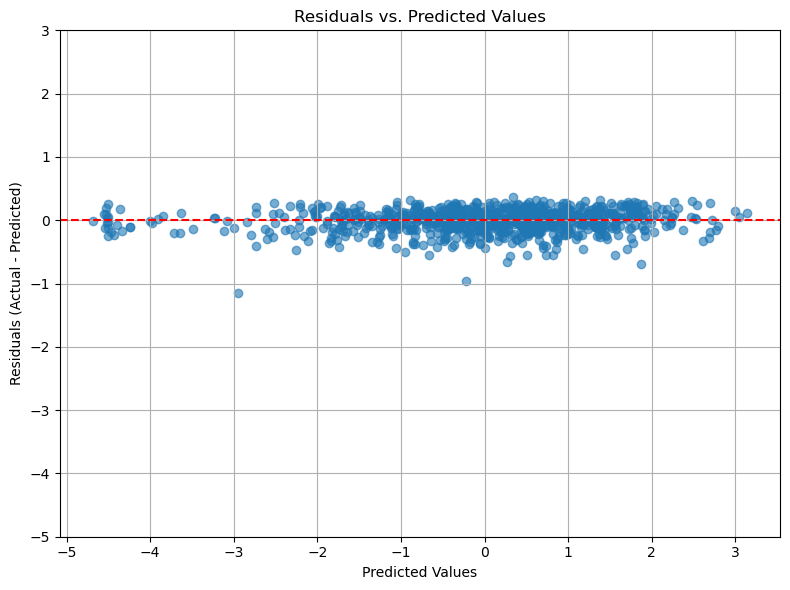

In [12]:
# Residuals = actual - predicted
residuals = Y_goat_TEST - y_predv1

plt.figure(figsize=(8, 6))
plt.scatter(Y_goat_TEST, y_predv1, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')

plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted Values")
plt.grid(True)
plt.ylim(-5,3)
plt.tight_layout()
plt.show()

## SHAP

### Investigate Shapely values

In [13]:
labels = {
  "activity_child_recoded": "Child's Activity",
  "trust_vip" : "Trust in VIP",
  "know_vip" : "Knows VIP",
  "educ_recoded_constant" : "Adult's Education",
  "agric_land" : "Owns Agricultural Land",
  "eng_language" : "English Language",
  "why_not_purchase_recoded" : "Reason Non-Purchase",
  "number_minors_z" : "Number of Minors in HH (z)",
  "number_adults_z" : "Number of Adults in HH (z)",
  "vip_trust_scale" : "Trust in VIP, Comp. Score (z)",
  "owns_phone" : "Owns Phone",
  "religion_recoded" : "Religion",
  "main_info_source_recoded" : "Main Info Source",
  "household_moved" : "Household Moved",
  "household_description" : "Household Status (Fully / Partially / Not Settled)",
  "age_constant_z" : "Age (z)",
  "educ_child_recoded" : "Child's Education",
  "expend" : "Expend",
  "irrigated_land_bin" : "Irrigated Land",
  "amh_language" : "Amh Language",
  "afm_language" : "Afm Language",

}

In [14]:
from catboost import Pool

# Create Pool for SHAP
X_pool = Pool(data=X_goat, cat_features=cat_features)

best_model = catboost_m1v1.best_estimator_

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_pool)


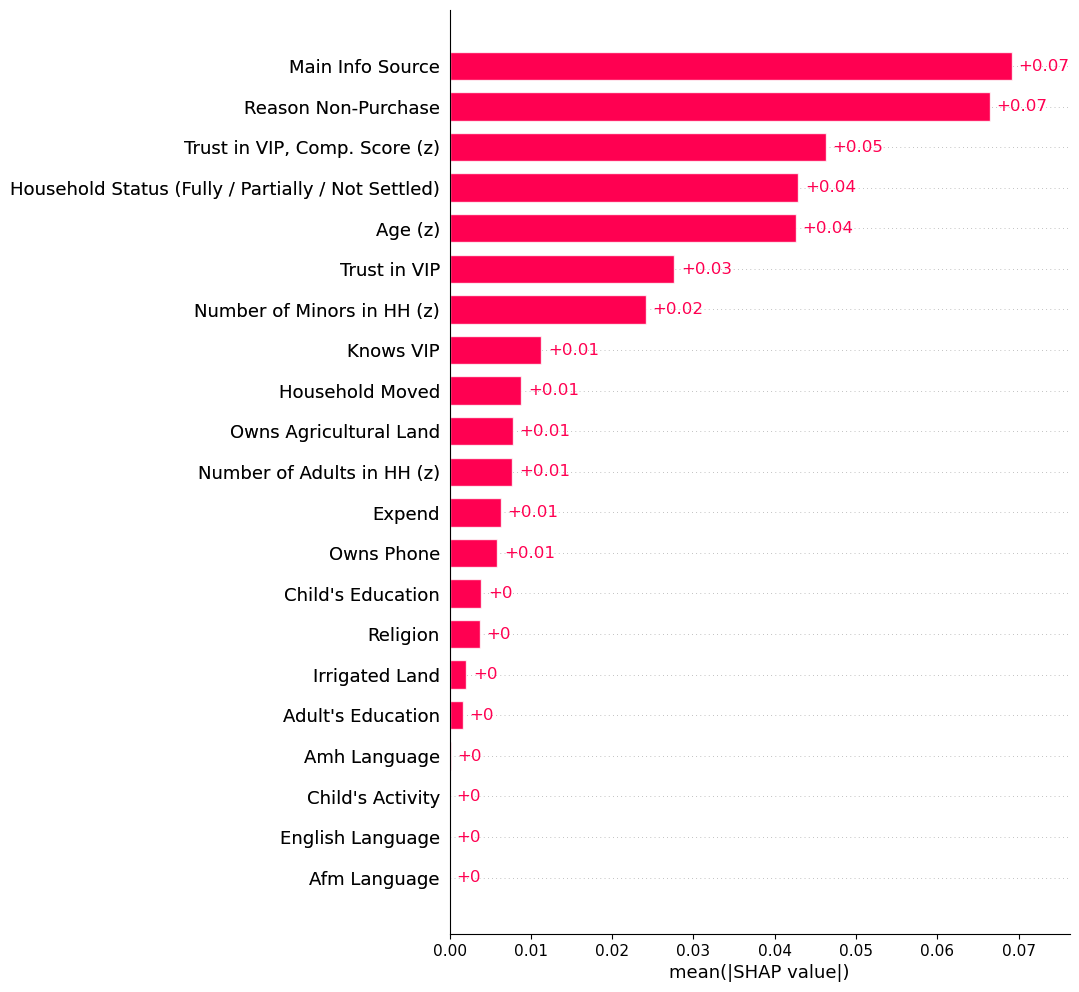

In [15]:
# Step 2: Create the CatBoost Pool (ensures correct internal handling)
X_pool = Pool(data=X_goat, cat_features=cat_features)

# Step 3: Create SHAP explainer
explainer = shap.Explainer(best_model)  # assumes your model is already trained

# Step 4: Get SHAP values using new API
shap_values = explainer(X_pool)

custom_names = [labels.get(col, col) for col in X_goat.columns]  # fallback to original name if not in dict
shap_values.feature_names = custom_names

# Step 5: Plot
shap.plots.bar(shap_values, max_display=50)

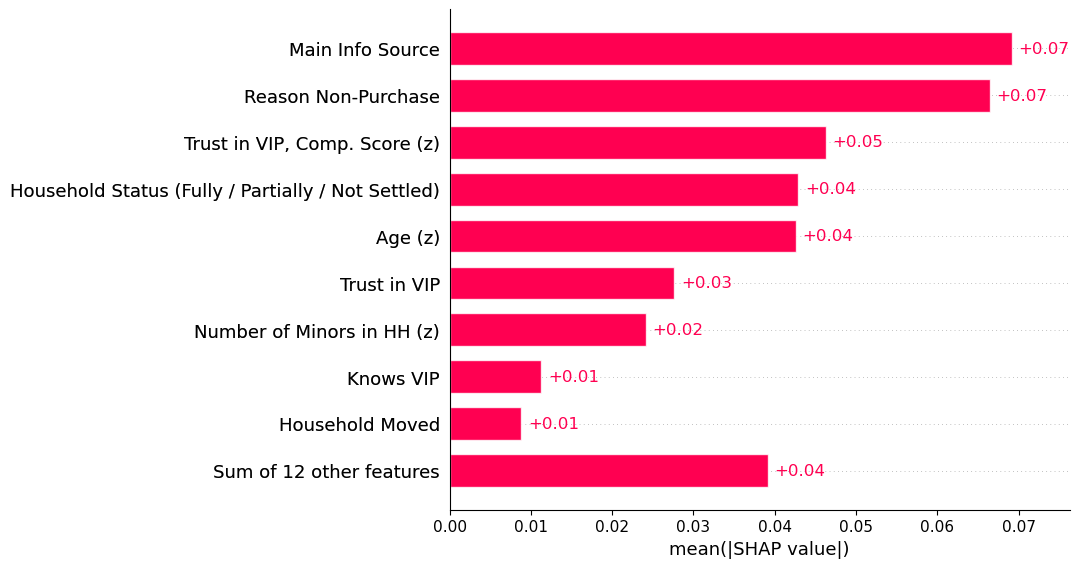

In [16]:
shap.plots.bar(shap_values, max_display=10)

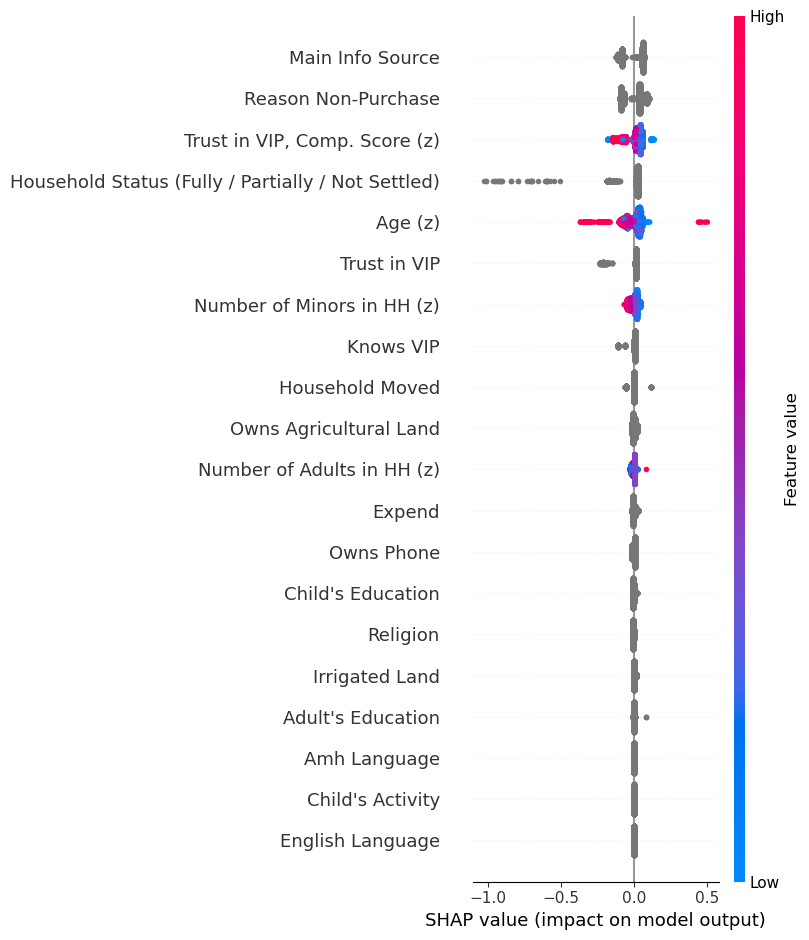

In [17]:
# Summary plot for all variables
X_goat_renamed = X_goat.rename(columns=labels)

shap.summary_plot(shap_values, features=X_goat, max_display=20)

Limit Plot to Top 10 Variables

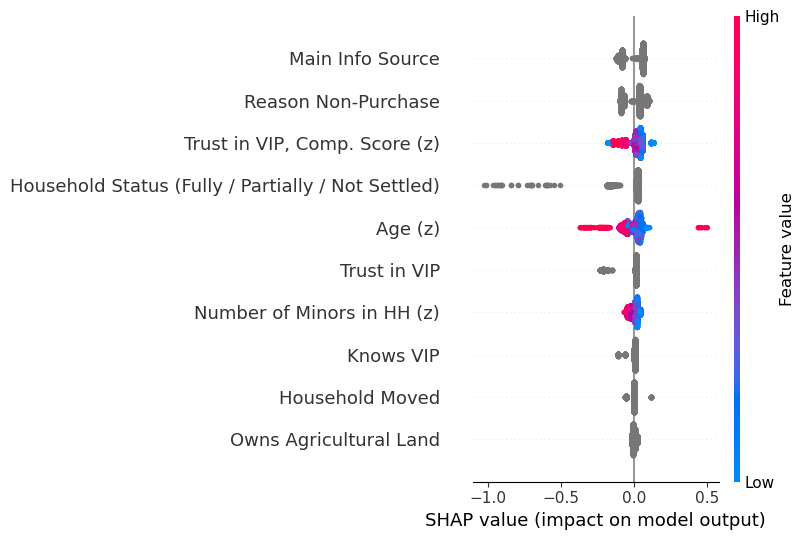

In [18]:
shap.summary_plot(shap_values, features=X_goat, max_display=10)

In [19]:
# set up explainer
explainer = shap.Explainer(best_model) 
shap_values = explainer(X_goat)        

C:\Users\Marion Späth\AppData\Local\Temp\ipykernel_51156\53399527.py:21: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


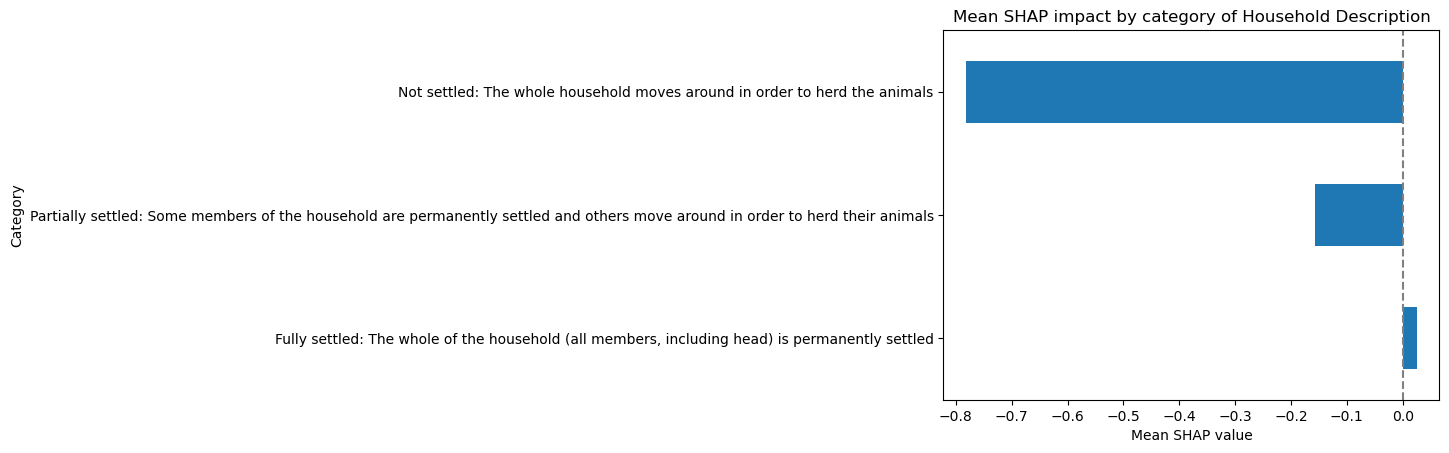

In [20]:
# Create SHAP DataFrame with renamed columns
shap_df = pd.DataFrame(
    shap_values.values,
    columns=[f"{col}_shap" for col in X_goat.columns]
)

# Join original data and SHAP values
joined = pd.concat([X_goat.reset_index(drop=True), shap_df.reset_index(drop=True)], axis=1)

# household_description
feature = "household_description"
shap_col = f"{feature}_shap"

category_shap_effects = joined.groupby(feature)[shap_col].agg(['mean', 'count', 'std']).sort_values(by='mean', ascending=False)

category_shap_effects['mean'].plot(kind='barh')
plt.xlabel("Mean SHAP value")
plt.title(f"Mean SHAP impact by category of Household Description")
plt.ylabel("Category")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

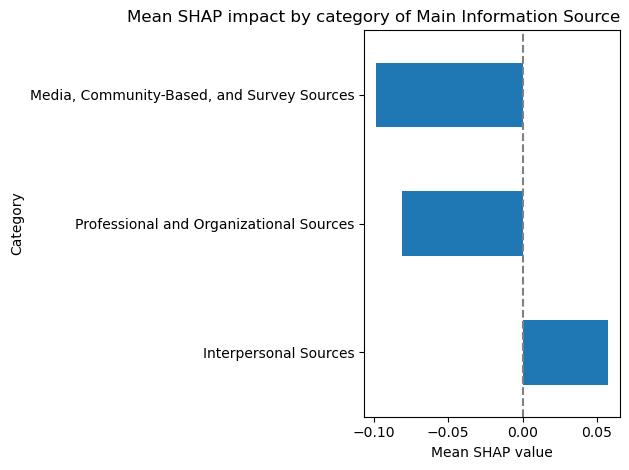

In [21]:
# main_info_source_recoded
feature = "main_info_source_recoded"
shap_col = f"{feature}_shap"

category_shap_effects = joined.groupby(feature)[shap_col].agg(['mean', 'count', 'std']).sort_values(by='mean', ascending=False)

category_shap_effects['mean'].plot(kind='barh')
plt.xlabel("Mean SHAP value")
plt.title(f"Mean SHAP impact by category of Main Information Source", loc='right')
plt.ylabel("Category")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

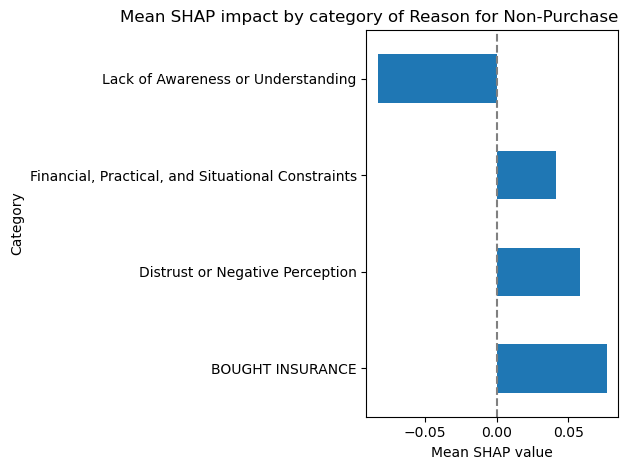

In [22]:
# main_info_source_recoded
feature = "why_not_purchase_recoded"
shap_col = f"{feature}_shap"

category_shap_effects = joined.groupby(feature)[shap_col].agg(['mean', 'count', 'std']).sort_values(by='mean', ascending=False)

category_shap_effects['mean'].plot(kind='barh')
plt.xlabel("Mean SHAP value")
plt.title("Mean SHAP impact by category of Reason for Non-Purchase", loc='right')
plt.ylabel("Category")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

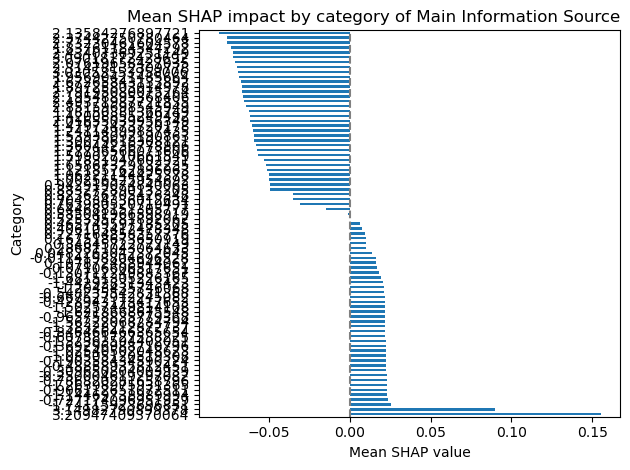

In [99]:
# main_info_source_recoded
feature = "age_constant_z"
shap_col = f"{feature}_shap"

category_shap_effects = joined.groupby(feature)[shap_col].agg(['mean', 'count', 'std']).sort_values(by='mean', ascending=False)

category_shap_effects['mean'].plot(kind='barh')
plt.xlabel("Mean SHAP value")
plt.title(f"Mean SHAP impact by category of Main Information Source", loc='right')
plt.ylabel("Category")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

### Get aggregated shapely values --> Overall feature importances

In [35]:
# aggregate SHAP values to get overall feature importances
feature_importance = pd.Series(
    np.abs(shap_df).mean(axis=0),
    index=shap_df.columns
).sort_values(ascending=True)
feature_importance

afm_language_shap                0.000000
eng_language_shap                0.000000
activity_child_recoded_shap      0.000000
amh_language_shap                0.000138
educ_recoded_constant_shap       0.001647
irrigated_land_bin_shap          0.002060
religion_recoded_shap            0.003718
educ_child_recoded_shap          0.003888
owns_phone_shap                  0.005872
expend_shap                      0.006315
number_adults_z_shap             0.007705
agric_land_shap                  0.007770
household_moved_shap             0.008824
know_vip_shap                    0.011304
number_minors_z_shap             0.024103
trust_vip_shap                   0.027630
age_constant_z_shap              0.042556
household_description_shap       0.042905
vip_trust_scale_shap             0.046260
why_not_purchase_recoded_shap    0.066443
main_info_source_recoded_shap    0.069172
dtype: float64

### convert to dataframe, give column names and save


In [36]:
feature_importance = feature_importance.reset_index()
feature_importance.columns = ['feature', 'importance']

feature_name_map = {
    "educ_recoded_constant_shap": "Adult's Education",
    "amh_language_shap": "Amh Language",
    "irrigated_land_bin_shap": "Irrigated Land",
    "expend_shap": "Expend",
    "eng_language_shap": "English Language",
    "afm_language_shap": "Afm Language",
    "educ_child_recoded_shap": "Child's Education",
    "activity_child_recoded_shap": "Child's Activity",
    "know_vip_shap": "Knows VIP",
    "age_constant_z_shap": "Age (z)",
    "trust_vip_shap": "Trust in VIP",
    "household_moved_shap": "Household Moved",
    "owns_phone_shap": "Owns Phone",
    "number_adults_z_shap": "Number of Adults in HH (z)",
    "religion_recoded_shap": "Religion",
    "number_minors_z_shap": "Number of Minors in HH (z)",
    "agric_land_shap": "Owns Agricultural Land",
    "main_info_source_recoded_shap": "Main Information Source",
    "household_description_shap": "Household Status",
    "why_not_purchase_recoded_shap": "Reason Non-Purchase",
    "vip_trust_scale_shap" : "Trust in VIP, Comp. Score (z)"

}

feature_importance["feature"] = feature_importance["feature"].replace(feature_name_map)
feature_importance

,feature,importance
0,Afm Language,0.000000
1,English Language,0.000000
2,Child's Activity,0.000000
3,Amh Language,0.000138
4,Adult's Education,0.001647
5,Irrigated Land,0.002060
6,Religion,0.003718
7,Child's Education,0.003888
8,Owns Phone,0.005872
9,Expend,0.006315


In [37]:
feature_importance.to_csv("feature_importance_catboost_goat_TRUST.csv", header=True, index=False)